# Statistical Downscaling of CanRCM4 Model Using 2.5 km HRDPS Data
## Data Preprocessing

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import pyproj
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from pathlib import Path

In [2]:
#load in data
#first world data from 2016-2020
P_world= xr.open_dataset("psl_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")

#next HRDPS data for all of 2016- end of 2019
path = Path("/home/rbeutel/analysis/eosc510/proj.ipynb").resolve().parents[2]
path2 = "/results/forcing/atmospheric/GEM2.5/operational/"

filename = []
for k in [6,7,8,9]:
    for i in range(12):
        if i+1 in [1,3,5,7,8,10,12]:
            for j in range(31):
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' +str(i+1)+ 'd0' +str(j+1)+ '.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0' + str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd'+ str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')
        elif i+1 == 2:
            for j in range(28): #it was a leap year in 2016 BUT model ignored it so we are ignoring it too
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0'+ str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')
        else:
            for j in range(30):
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0'+ str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')

In [3]:
files = [path/path2/filename[i] for i in range(len(filename))]
hrdps = xr.open_mfdataset(files)

/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

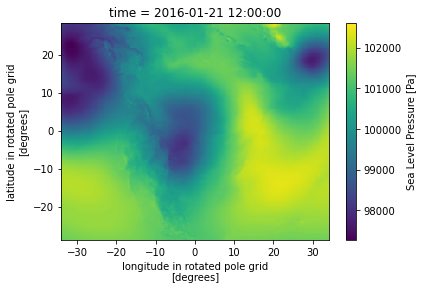

In [4]:
P_world.psl[20,:,:].plot()
#plt.savefig('RCMdata.png')

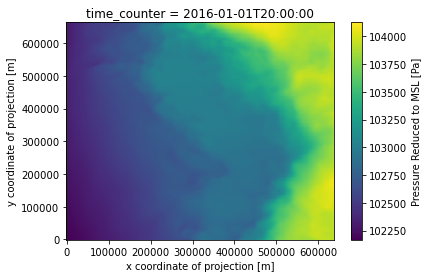

In [5]:
hrdps.atmpres[20,:,:].plot()
#plt.savefig('HRDPSdata.png')

In [6]:
#next we want the HRDPS data to be daily instead of hourly
hrdps = hrdps.resample(time_counter='D').mean(dim='time_counter')

In [7]:
#find index of extra day (leap day)
ind = list(hrdps.time_counter.values).index(np.datetime64('2016-02-29T00:00:00.000000000'))

In [8]:
#and then trim the components you want to work with to be in a more relevant extent 
#(dont need the HRDPS data to stretch as far as it does inland)
p_temp = np.concatenate((hrdps.atmpres.sel(x=slice(0., 480000.)).values[0:ind,:,:], hrdps.atmpres.sel(x=slice(0., 480000.)).values[(ind+1):,:,:]))
hrdps_lat = hrdps.nav_lat.sel(x=slice(0., 480000.)).values
hrdps_lon = hrdps.nav_lon.sel(x=slice(0., 480000.)).values

In [9]:
#now extract the lat, lon, U, and V and get into form that I can work with
hrdps_lat = hrdps_lat[0,:,:].flatten()
hrdps_lon = hrdps_lon[0,:,:].flatten()

In [10]:
#U and V to 2D - space is the m component in my research question not time
P_hrdps = np.empty((np.shape(p_temp)[1]*np.shape(p_temp)[2],np.shape(p_temp)[0]))
for i in range(np.shape(p_temp)[0]):
    P_hrdps[:,i] = np.reshape(p_temp[i],(np.shape(p_temp)[1]*np.shape(p_temp)[2],))

In [11]:
#replace all nan with atmospheric pressure (101325 Pa)
P_hrdps = (pd.DataFrame(P_hrdps).fillna(101325)).to_numpy() 

#normalize the data
#P_hrdps = (P_hrdps - P_hrdps.mean())/P_hrdps.std()

In [12]:
#trim the world dataset to be for right time extent
#want days between June 1 2018 and June 30 2018
P_world = P_world.sel(time=slice('2016-01-01 12:00:00', '2019-12-31 12:00:00')) #model does not do leap day so don't load in leap day from hrdps

In [13]:
#now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
#first decide on range you want to work within for CanRCM4 data, want to overlap the HRDPS data by 10% of the max distance (y)
buffer = (max(hrdps_lat)-min(hrdps_lat))*0.1

lon = P_world.lon.values.flatten()
lat = P_world.lat.values.flatten()
index = []

#first find idexes that fit into lon range and lat range
for i in range(len(lon)):
    if lon[i] > (min(hrdps_lon)-buffer) and lon[i] < (max(hrdps_lon)+buffer) and lat[i] > (min(hrdps_lat)-buffer) and lat[i] < (max(hrdps_lat)+buffer):
        index.append(i)

#now make new lat, and lon
lat_RCM = []
lon_RCM = []

for i in index:
    lat_RCM.append(lat[i])
    lon_RCM.append(lon[i])

In [14]:
#now convert the wind data to 2D and use the idices found in the previous step to trim it
P2d = np.empty((np.shape(P_world.psl.values)[1]*np.shape(P_world.psl.values)[2],np.shape(P_world.psl.values)[0]))
for i in range(np.shape(P_world.psl.values)[0]):
    P2d[:,i] = np.reshape(P_world.psl.values[i],(np.shape(P_world.psl.values)[1]*np.shape(P_world.psl.values)[2],))

P_RCM = np.empty((len(index),np.shape(P_world.psl.values)[0]))

for i in range(np.shape(P_hrdps)[1]):
    for j in range(len(index)):
        P_RCM[j,i] = P2d[index[j],i]

In [15]:
#normalize the data
#P_RCM = (P_RCM - P_RCM.mean())/P_RCM.std()

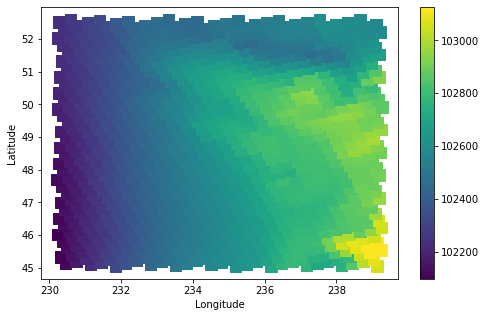

In [16]:
#visualize preprocessing
plt.figure(figsize=(8,5))

plt.scatter(lon_RCM, lat_RCM,
            c = P_RCM[:,0],
            cmap = 'viridis',
            s = 133,
            marker = 's')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

## PCA 
First on CanRCM4 Model

In [17]:
#PCA on the world data
#looking for dominant spatial patterns to be eigenvectors and how those spatial patterns evelove over the month to the the PCs)
#need to take the transpose of the matrix 

data = P_RCM.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
RCM_PCs = pca.fit_transform(data)
RCM_eigvecs = pca.components_
RMCfracVar = pca.explained_variance_ratio_

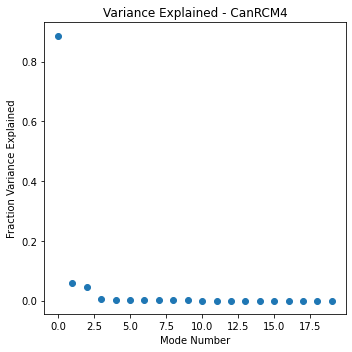

In [18]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(RMCfracVar[0:20])),RMCfracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - CanRCM4')

plt.tight_layout()

plt.show()

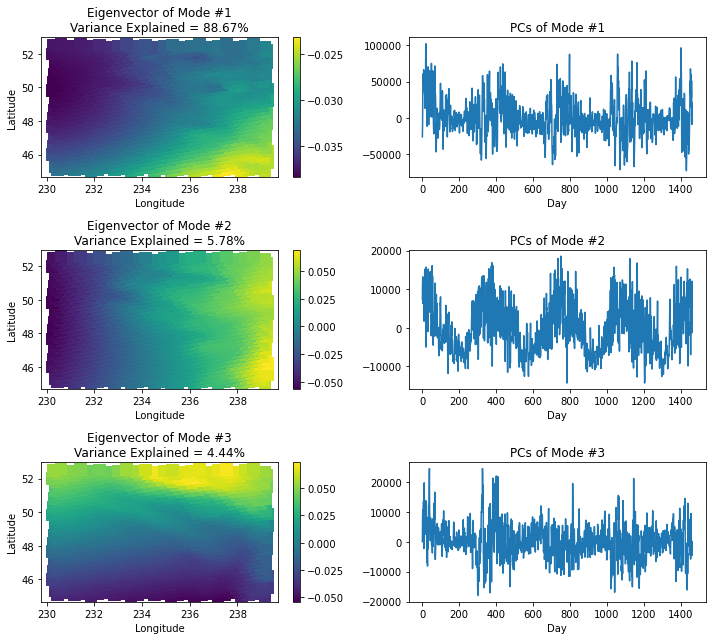

In [19]:
#keep first three modes
#visualise P component
n = 3
day1 = 1
dayfinal = len(data)

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(lon_RCM, lat_RCM,
            c = RCM_eigvecs[kk,:],
            cmap = 'viridis',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(RMCfracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
#plt.savefig('PCA-RCM-P.png')

Now on the HRDPS Data

In [20]:
#PCA on the HRDPS data 
data = P_hrdps.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
hrdps_PCs = pca.fit_transform(data)
hrdps_eigvecs = pca.components_
hrdps_fracVar = pca.explained_variance_ratio_

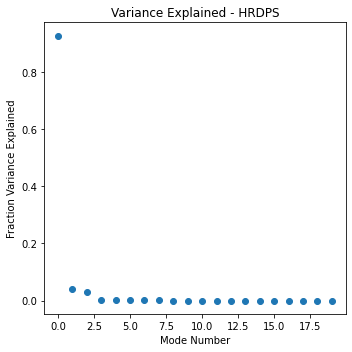

In [21]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracVar[0:20])),hrdps_fracVar[0:20]) #plot only first 20
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - HRDPS')

plt.tight_layout()

plt.show()

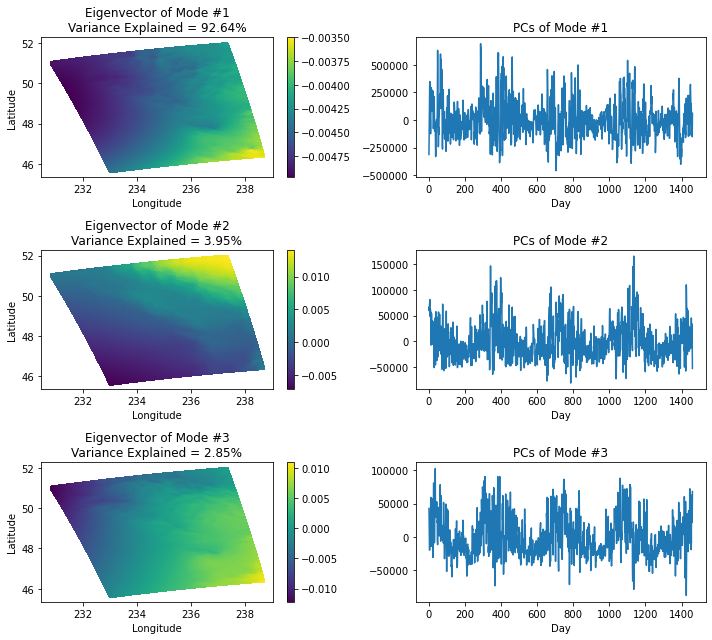

In [22]:
#keep first mode
#visualise
n = 3

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

#plt.savefig('PCA-HRDPS-U.png')

## Grid-search optimization

In [23]:
#define RMSE as a function
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

Making a seperate NN for each HRDPS PC (use three at first and then analyse difference of just using 1)

In [28]:
#set training and validation data - for 1st HRDPS PC
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
nPCs_RCM = 3
nPCs_hrdps = 1

x = RCM_PCs[:,:nPCs_RCM] #CanRCM4 PCAs as input
y = np.squeeze(hrdps_PCs[:,:nPCs_hrdps]) #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
x_train = x[:Ntrain]
y_train = y[:Ntrain]
x_test = x[Ntrain:]
y_test = y[Ntrain:]

#unit based normalization wrt training set
xmax = np.max(y_train,axis=0)
xmin = np.min(y_train,axis=0)
ymax = np.max(y_train,axis=0)
ymin = np.min(y_train,axis=0)

x_train-=xmin
x_train/=(xmax-xmin)
x_test-=xmin
x_test/=(xmax-xmin)
y_train-=ymin
y_train/=(ymax-ymin)
y_test-=ymin
y_test/=(ymax-ymin)

In [29]:
np.shape(y.T)

(1460,)

In [30]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 243 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 2 hidden layers, 25 hidden neurons
Model Number: 1
	 BEST: 1 hidden layers, 189 hidden neurons
Model Number: 2
	 BEST: 1 hidden layers, 40 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 160 hidden neurons
Model Number: 4
	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 5
	 BEST: 2 hidden layers, 124 hidden neurons
Model Number: 6
	 BEST: 2 hidden layers, 25 hidden neurons
Model Number: 7
	 BEST: 1 hidden layers, 19 hidden neurons
Model Number: 8
	 BEST: 1 hidden layers, 154 hidden neurons
Model Number: 9
	 BEST: 1 hidden layers, 160 hidden neurons
Model Number: 10
	 BEST: 2 hidden layers, 135 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 198 hidden neurons
Model Number: 12
	 BEST: 1 hidden layers, 128 hidden neurons
Model Number: 13
	 BEST: 1 hidden layers, 129 hidden neurons
Model Number: 14
	 BEST: 1 hidden layers, 92 hidden neurons
Model Number: 15
	 BEST: 1 hidden layers, 17 hidden neurons
Model Number: 16
	 BEST: 1 hidden layers, 

In [36]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
PC1model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(PC1model)

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(12, 1),
             learning_rate_init=0.01, max_iter=2000, solver='sgd',
             validation_fraction=0.2)


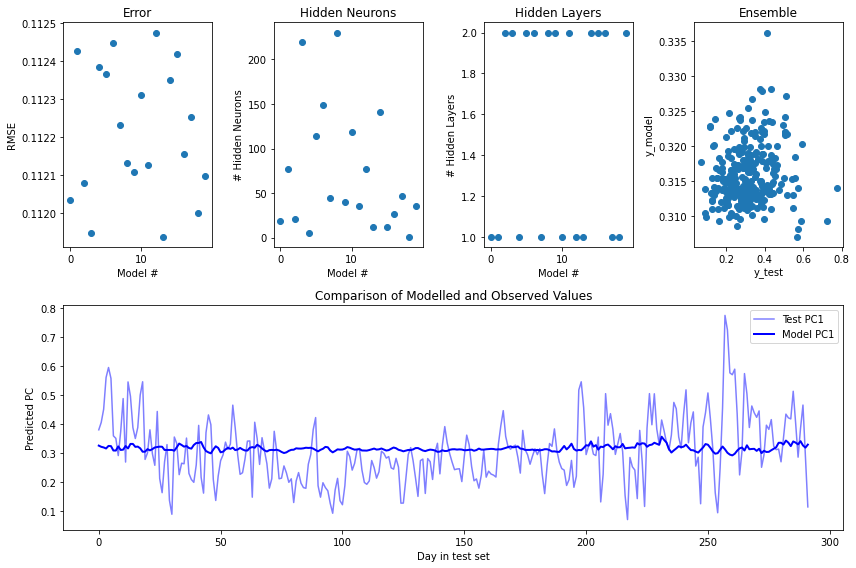

In [38]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
#plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_test,alpha=0.5, label='Test PC1', c='b')
# plt.plot(y_test[:,1],alpha=0.5, label='Test PC2', c='g')
# plt.plot(y_test[:,2],alpha=0.5, label='Test PC3', c='r')
plt.plot(PC1model.predict(x_test), label='Model PC1', c='b', lw=2)
# plt.plot(PC1model.predict(x_test)[:,1], label='Model PC2', c='g', lw=2)
# plt.plot(PC1model.predict(x_test)[:,2], label='Model PC3', c='r', lw=2)
# plt.plot(y_out_ensemble_mean[:,0], label='Model PC1', c='b', lw=2)
# plt.plot(y_out_ensemble_mean[:,1], label='Model PC2', c='g', lw=2)
# plt.plot(y_out_ensemble_mean[:,2], label='Model PC3', c='r', lw=2)
plt.legend()
plt.xlabel('Day in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

In [40]:
#set training and validation data - for 2nd HRDPS PC
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
#NOTE: we only need to reset output (y)

nPCs_hrdps = 2

y = np.squeeze(hrdps_PCs[:,(nPCs_hrdps-1):nPCs_hrdps]) #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
y_train = y[:Ntrain]
y_test = y[Ntrain:]

#unit based normalization wrt training set
ymax = np.max(y_train,axis=0)
ymin = np.min(y_train,axis=0)

y_train-=ymin
y_train/=(ymax-ymin)
y_test-=ymin
y_test/=(ymax-ymin)

In [ ]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 243 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

In [ ]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
PC2model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(PC2model)

In [ ]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
#plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_test,alpha=0.5, label='Test PC1', c='g')
plt.plot(PC1model.predict(x_test), label='Model PC1', c='g', lw=2)
plt.legend()
plt.xlabel('Day in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

In [ ]:
#set training and validation data - for 3rd HRDPS PC
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
#NOTE: we only need to reset output (y)

nPCs_hrdps = 3

y = np.squeeze(hrdps_PCs[:,(nPCs_hrdps-1):nPCs_hrdps]) #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
y_train = y[:Ntrain]
y_test = y[Ntrain:]

#unit based normalization wrt training set
ymax = np.max(y_train,axis=0)
ymin = np.min(y_train,axis=0)

y_train-=ymin
y_train/=(ymax-ymin)
y_test-=ymin
y_test/=(ymax-ymin)

In [ ]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 243 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

In [ ]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
PC3model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(PC3model)

In [ ]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
#plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_test,alpha=0.5, label='Test PC1', c='r')
plt.plot(PC1model.predict(x_test), label='Model PC1', c='r', lw=2)
plt.legend()
plt.xlabel('Day in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

In [ ]:
# plt.figure(figsize=(12,8))


# plt.subplot(311)
# plt.plot(y[:,0],alpha=0.2, label='PC1', c='b')
# plt.plot(model.predict(x)[:,0], label='Model PC1', c='b', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')
# plt.title('Comparison of Modelled and Observed Values')

# plt.subplot(312)
# plt.plot(y[:,1],alpha=0.2, label='PC2', c='g')
# plt.plot(model.predict(x)[:,1], label='Model PC2', c='g', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')

# plt.subplot(313)
# plt.plot(y[:,2],alpha=0.2, label='PC3', c='r')
# plt.plot(model.predict(x)[:,2], label='Model PC3', c='r', lw=2)
# plt.legend()
# plt.xlabel('Day in test set')
# plt.ylabel('Predicted PC')

## Future prediction and reconstruction

In [79]:
#reconstruct - with model PCs

PCs = model.predict(x)
#PCs = PCs*(xmax-xmin)+xmin


numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*PCs[kk,mode]    
    data_rec[kk,:] = this_rec

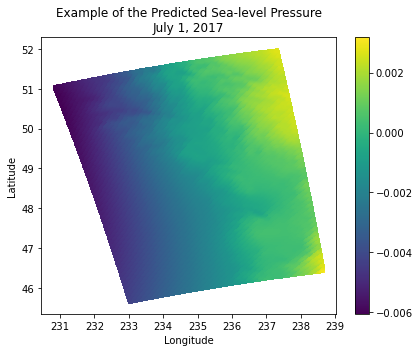

In [80]:
#visualize reconstruction - with model PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the Predicted Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()

In [75]:
#reconstruct - with actual PCs

numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*hrdps_PCs[kk,mode]    
    data_rec[kk,:] = this_rec

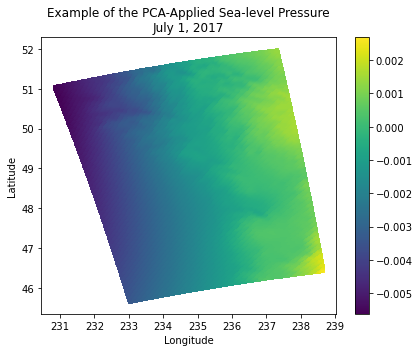

In [76]:
#visualize reconstruction - with actual PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the PCA-Applied Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()